In [1]:
import xarray as xr
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Determine the device to use
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [3]:
# Loading and combining datasets
path = "./data"
nc_files = glob.glob(os.path.join(path, "*.nc"))

datasets = [xr.open_dataset(f, engine='netcdf4') for f in nc_files]

combined_ds = xr.concat(datasets, dim='time')

In [4]:
# Defining the config and hyperparameters
config = {
    'time_step': 1,
    'batch_size': 16,
    'num_epochs':50,
    'learning_rate': 1e-4,
    'test_size': 0.2,
}

In [5]:
# Standardize the data
mean_tas = combined_ds.tas.mean(dim='time', skipna=True)
std_tas = combined_ds.tas.std(dim='time', skipna=True)

standardized_tas = (combined_ds.tas - mean_tas) / std_tas

time_index = 0
standardized_tas_slice = standardized_tas.isel(time=time_index)

/opt/homebrew/anaconda3/envs/data_readiness/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [6]:
# # Fill nan values with 0s
filled_standardized_tas = standardized_tas.fillna(0)
filled_standardized_tas = combined_ds.tas.fillna(0)

data = filled_standardized_tas.values.astype(np.float32)

data_shape = data.shape

if len(data_shape) < 2:
    raise ValueError("Data must have at least two dimensions for x and y.")

x_dim = data_shape[-2]
y_dim = data_shape[-1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_data = np.pad(data, ((0, 0),) * (len(data_shape) - 2) + ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_data = np.expand_dims(padded_data, axis=1)
expanded_data.shape

(240, 1, 56, 56)

In [7]:
# Create a dataset to serve the data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, time_step=1):
        self.time_step = time_step
        self.data = data

    def __len__(self):
        return len(self.data) - self.time_step * 2

    def __getitem__(self, idx):
        return np.concatenate((self.data[idx], self.data[idx+self.time_step]), axis=0), self.data[idx+self.time_step*2]

dataset = TimeSeriesDataset(expanded_data)

In [8]:
# Split into test and train datasets
test_size = int(len(dataset) * config['test_size'])
train_size = len(dataset) - test_size 

indices = np.arange(len(dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

In [ ]:
# Define model
class CNNTimeSeriesForecast(nn.Module):
    def __init__(self, input_size, mlp_expand_size=4):
        super(CNNTimeSeriesForecast, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_size[0], 4, kernel_size=(3,3), stride=2, padding=(1, 1)),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(3,3), stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(1,1), stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv_transpose3 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_transpose1 = nn.ConvTranspose2d(4, input_size[0], kernel_size=3, stride=2, padding=1, output_padding=1)

        self.activation = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        x = self.bottleneck(x3)

        x = x + x3
        x = self.activation(self.conv_transpose3(x))
        x = x + x2  
        x = self.activation(self.conv_transpose2(x))
        x = x + x1  
        x = self.conv_transpose1(x)

        return x

dummy_input= next(iter(test_loader))[0].to(device)
model = CNNTimeSeriesForecast(input_size=dummy_input[0].shape).to(device)

model(dummy_input).shape

torch.Size([16, 2, 56, 56])

In [10]:
# Create a mask over the non-null values
non_null_mask = combined_ds.tas.notnull()
collapsed_mask = np.all(non_null_mask.values, axis=0)

mask_shape = collapsed_mask.shape
x_dim = mask_shape[0]
y_dim = mask_shape[1]

target_size = max(x_dim, y_dim)
if target_size % 8 != 0:
    target_size = ((target_size // 8) + 1) * 8

x_padding = target_size - x_dim
x_left_padding = x_padding // 2
x_right_padding = x_padding - x_left_padding

y_padding = target_size - y_dim
y_left_padding = y_padding // 2
y_right_padding = y_padding - y_left_padding

padded_mask = np.pad(collapsed_mask, ((x_left_padding, x_right_padding), (y_left_padding, y_right_padding)), mode='constant', constant_values=0)

expanded_mask = np.expand_dims(padded_mask, axis=0)

batch_size = config['batch_size']
batch_mask = np.repeat(expanded_mask[np.newaxis, :, :], batch_size, axis=0)

mask_tensor = torch.from_numpy(batch_mask.astype(np.float32)).to(device)
mask_tensor.shape

torch.Size([16, 1, 56, 56])

In [11]:
# Training set up
criterion = nn.MSELoss(reduction='none')  
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [12]:
# Training loop
for epoch in range(config['num_epochs']):
    model.train()  
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']-1}", leave=False)
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)

        # Apply the mask to the outputs and labels
        masked_loss = criterion(outputs, labels) * mask_tensor
        loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Train Loss': loss.item()})

    train_loss /= len(train_loader)

    model.eval()  
    test_loss = 0.0
    with torch.no_grad():  
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)

            # Apply the mask to the outputs and labels
            masked_loss = criterion(outputs, labels) * mask_tensor
            loss = masked_loss.sum() / mask_tensor.sum()  # Normalize by the number of valid elements
            test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch [{epoch}/{config['num_epochs']-1}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 0/49:   0%|          | 0/11 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/data_readiness/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 56, 56])) that is different to the input size (torch.Size([16, 2, 56, 56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/49], Train Loss: 204.0900, Test Loss: 236.8374


Epoch [1/49], Train Loss: 205.2324, Test Loss: 236.1775


Epoch [2/49], Train Loss: 203.9300, Test Loss: 235.0661


Epoch [3/49], Train Loss: 203.8972, Test Loss: 233.9356


Epoch [4/49], Train Loss: 200.6292, Test Loss: 232.6564


Epoch [5/49], Train Loss: 205.3541, Test Loss: 231.3663


Epoch [6/49], Train Loss: 205.1684, Test Loss: 230.0810


Epoch [7/49], Train Loss: 198.1605, Test Loss: 228.2905


Epoch [8/49], Train Loss: 198.4669, Test Loss: 226.7437


Epoch [9/49], Train Loss: 196.7037, Test Loss: 224.5021


Epoch [10/49], Train Loss: 196.1064, Test Loss: 222.5657


Epoch [11/49], Train Loss: 191.9143, Test Loss: 220.4331


Epoch [12/49], Train Loss: 192.3631, Test Loss: 217.4647


Epoch [13/49], Train Loss: 182.3178, Test Loss: 214.0659


Epoch [14/49], Train Loss: 187.1089, Test Loss: 210.6398


Epoch [15/49], Train Loss: 184.2934, Test Loss: 207.1495


Epoch [16/49], Train Loss: 182.6892, Test Loss: 203.7966


Epoch [17/49], Train Loss: 176.1847, Test Loss: 199.8395


Epoch [18/49], Train Loss: 171.7532, Test Loss: 194.5217


Epoch [19/49], Train Loss: 171.5603, Test Loss: 191.0060


Epoch [20/49], Train Loss: 163.3179, Test Loss: 185.8906


Epoch [21/49], Train Loss: 156.9776, Test Loss: 180.8713


Epoch [22/49], Train Loss: 153.2977, Test Loss: 176.8706


Epoch [23/49], Train Loss: 157.5529, Test Loss: 172.6129


Epoch [24/49], Train Loss: 149.4685, Test Loss: 168.8562


Epoch [25/49], Train Loss: 148.9936, Test Loss: 164.7194


Epoch [26/49], Train Loss: 137.5231, Test Loss: 160.9851


Epoch [27/49], Train Loss: 140.3859, Test Loss: 157.1714


Epoch [28/49], Train Loss: 137.0793, Test Loss: 153.2621


Epoch [29/49], Train Loss: 130.6183, Test Loss: 150.8475


Epoch [30/49], Train Loss: 127.7521, Test Loss: 146.6643


Epoch [31/49], Train Loss: 124.9040, Test Loss: 143.0914


Epoch [32/49], Train Loss: 125.0249, Test Loss: 138.7676


Epoch [33/49], Train Loss: 115.2503, Test Loss: 136.0966


Epoch [34/49], Train Loss: 115.7378, Test Loss: 131.0898


Epoch [35/49], Train Loss: 113.4615, Test Loss: 126.3577


Epoch [36/49], Train Loss: 111.0694, Test Loss: 124.3410


Epoch [37/49], Train Loss: 104.7700, Test Loss: 120.3701


Epoch [38/49], Train Loss: 103.1035, Test Loss: 116.9375


Epoch [39/49], Train Loss: 102.5555, Test Loss: 113.5835


Epoch [40/49], Train Loss: 97.6263, Test Loss: 109.7647


Epoch [41/49], Train Loss: 93.1750, Test Loss: 106.5308


Epoch [42/49], Train Loss: 91.2819, Test Loss: 102.3916


Epoch [43/49], Train Loss: 89.1117, Test Loss: 99.4535


Epoch [44/49], Train Loss: 89.0503, Test Loss: 97.4267


Epoch [45/49], Train Loss: 82.4039, Test Loss: 93.1588


Epoch [46/49], Train Loss: 78.1668, Test Loss: 90.3950


Epoch [47/49], Train Loss: 80.0262, Test Loss: 85.8769


Epoch [48/49], Train Loss: 72.9551, Test Loss: 84.2035


Epoch [49/49], Train Loss: 72.7073, Test Loss: 81.3504


In [13]:
# Run the model on one example
features, labels = next(iter(test_loader))
features, labels = features.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(features)

features = features.cpu().numpy()
labels = labels.cpu().numpy()
outputs = outputs.cpu().numpy()
mask = mask_tensor.cpu().numpy()

masked_output = outputs * mask

difference = labels - masked_output

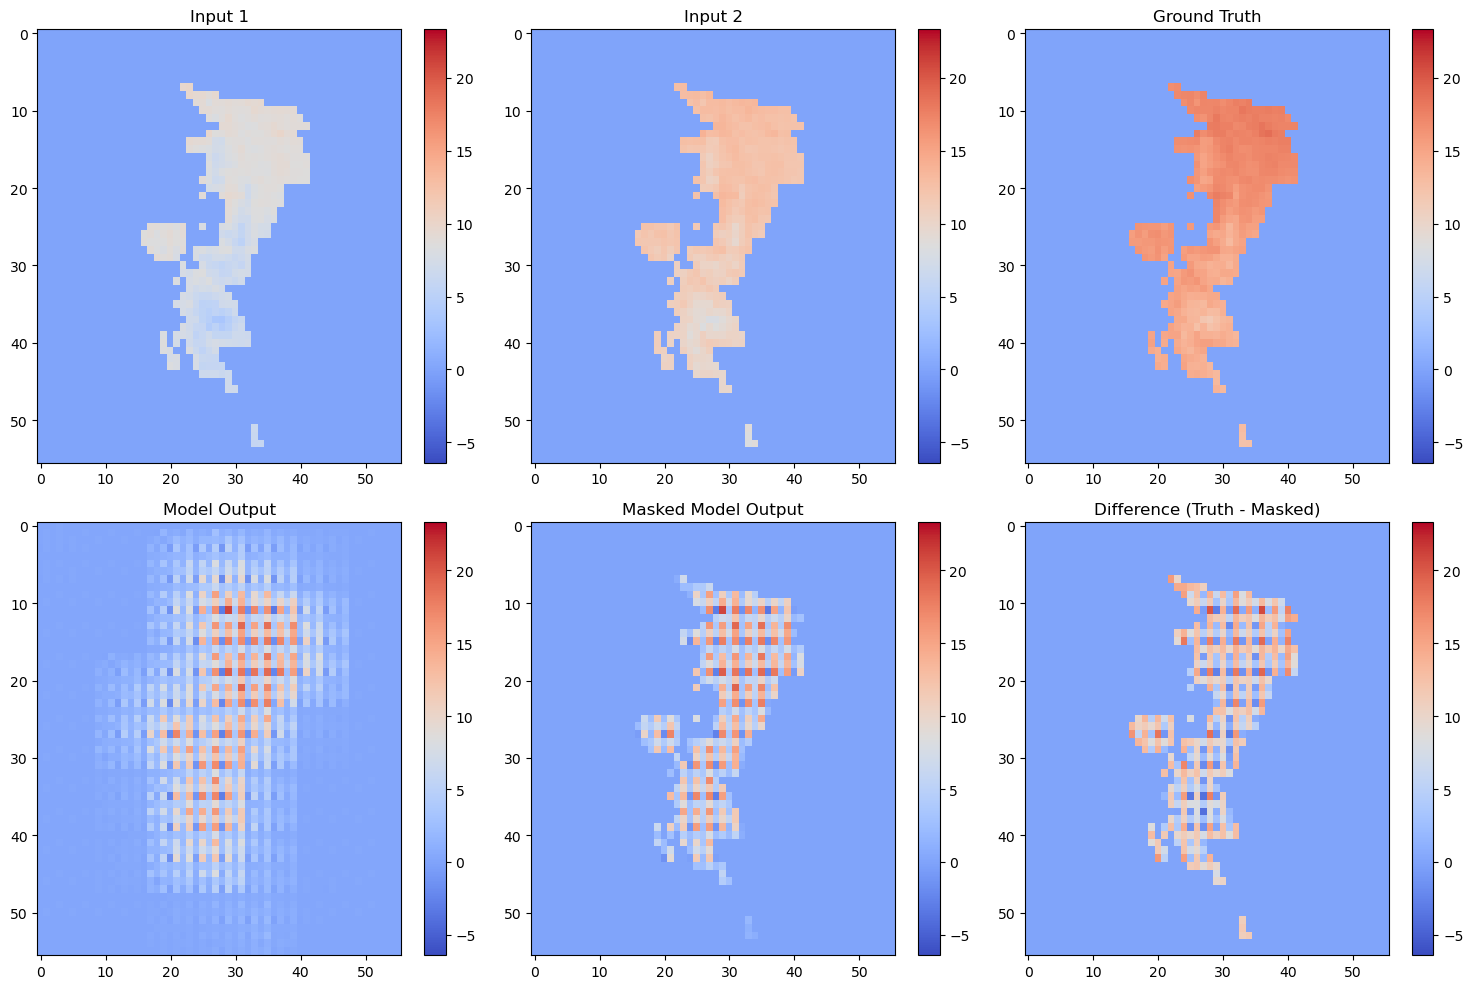

In [14]:
# Visualise the input and output data
sample_index = 4
vmin = min(features[sample_index].min(), labels[sample_index].min(), masked_output[sample_index].min(), difference[sample_index].min())
vmax = max(features[sample_index].max(), labels[sample_index].max(), masked_output[sample_index].max(), difference[sample_index].max())

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(features[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 1')
plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(features[sample_index, 1], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Input 2')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(labels[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(outputs[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Model Output')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(masked_output[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Masked Model Output')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(difference[sample_index, 0], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
plt.title('Difference (Truth - Masked)')
plt.colorbar()

plt.tight_layout()
plt.show()